Basic classification of stadsarchief images
Network based on: https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f

In [12]:
import numpy as np
import math
from PIL import Image
from scipy import misc
import keras.backend as K

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.initializers import RandomUniform
from keras.layers import LeakyReLU

from stats import list_stats
from data import load_data

In [2]:
# IMG_DIR = 'examples/0-src/200x200/';
# LABEL_DIR = 'examples/0-src/labels/';
IMG_DIR = 'examples/0-src/beeldbank-scraped_set/300x300/';
LABEL_DIR = 'examples/0-src/beeldbank-scraped_set/labels/';
img_dim = (300, 300, 3);

[X, Y_yaml] = load_data(IMG_DIR, LABEL_DIR)
Y_type = np.array([y.get('type') for y in Y_yaml])

def shuffle(X, Y):
    indices = np.random.permutation(X.shape[0])
    X_shuffled = X[indices]
    Y_shuffled = Y[indices]
    return (X_shuffled, Y_shuffled)
# print(X.shape)

print('shuffling X and Y')
X_shuffled, Y_shuffled = shuffle(X, Y_type)
X = X_shuffled
Y_type = Y_shuffled

# def simplify_Y(Y):
#     return np.array([y if y == 'blueprint' else 'other' for y in Y])

# Y_type = simplify_Y(Y_type)

first few ids: ['000000091010', '000000091053', '000000091089', '000000091123', '000000091242']
shuffling X and Y


In [3]:
print(f"shape X: {X.shape}")
print(f"shape Y: {Y_type.shape}")

list_stats(Y_type)

shape X: (1201, 300, 300, 3)
shape Y: (1201,)
classes: 5
[['foto', 250], ['kaart', 30], ['affiche', 8], ['bouwtekening', 338], ['prent', 575]]


In [7]:
# Convert string to idx
types = list(set(Y_type))
num_classes = len(types)
print(f"number of classes: {num_classes}")
print(f"types encountered: {types}")

def convert_to_index(Y, types):
    return np.array([types.index(y) for y in Y])

Yind = convert_to_index(Y_type, types)
print(Y_type[:3])
print(Yind[:3])

list_stats(Yind)

number of classes: 5
types encountered: ['foto', 'kaart', 'affiche', 'bouwtekening', 'prent']
['foto' 'bouwtekening' 'bouwtekening']
[0 3 3]
classes: 5
[[0, 250], [1, 30], [2, 8], [3, 338], [4, 575]]


In [ ]:
# def set_class(Y, class_idx):
#     print(Y)
#     Y[:] = class_idx
#     print(Y)
#     return Y
# # YInd = set_class(Yind, 0)

In [10]:
Y = keras.utils.to_categorical(Yind, num_classes)  # convert class vectors to binary class matrices
print(Yind.shape)
print(Y.shape)

(1201,)
(1201, 5)


(1201, 300, 300, 3)

In [14]:
# Split to train and test
def split_data(X, Y, size):
    X_train = X[:N]
    Y_train = Y[:N]
    X_test = X[N:]
    Y_test = Y[N:]
    return (X_train, Y_train), (X_test, Y_test)

total = X.shape[0]
img_dim = (200, 200, 3);
N = math.floor(0.8 * total)
(X_train, Y_train), (X_test, Y_test) = split_data(X, Y, N)
print("")
print("split data shapes:")
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


split data shapes:
(960, 300, 300, 3)
(960, 5)
(241, 300, 300, 3)
(241, 5)


In [15]:
def list_stats(X, Y):
    Yidx = np.argmax(Y, axis=1)
    unique, counts = np.unique(Yidx, return_counts=True)
    print(dict(zip(unique, counts)))
print("stats train: ")
list_stats(X_train, Y_train)
print("stats test: ")
list_stats(X_test, Y_test)

train: 
{0: 200, 1: 23, 2: 5, 3: 273, 4: 459}
test: 
{0: 50, 1: 7, 2: 3, 3: 65, 4: 116}


In [22]:
resize = 200
print("split data shapes:")
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
X_train = X_train[:, :resize, :resize, :]
X_test = X_test[:, :resize, :resize, :]
print("split data shapes:")
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
img_dim = (resize, resize, 3);

split data shapes:
(960, 300, 300, 3)
(960, 5)
(241, 300, 300, 3)
(241, 5)
split data shapes:
(960, 200, 200, 3)
(960, 5)
(241, 200, 200, 3)
(241, 5)


In [23]:
# def build_model(num_classes, img_dim):
#     model = Sequential()
#     model.add(Conv2D(32, kernel_size=(3, 3),
#                      activation='relu',
#                      input_shape=img_dim))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model

def build_model(num_classes, img_dim):
    print(img_dim)
    model = Sequential()
    model.add(Conv2D(2, kernel_size=(3, 3),
                     activation='linear',
                     input_shape=img_dim,
                     kernel_initializer = RandomUniform()
                    ))
    model.add(LeakyReLU())
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))

    model.add(Flatten())    
#     model.add(Flatten(input_shape=img_dim))
    model.add(Dense(16, activation='linear', kernel_initializer = RandomUniform()))
    model.add(LeakyReLU())
#     model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model
model = build_model(num_classes, img_dim)
model.summary()

(200, 200, 3)
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 2)       56        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 198, 198, 2)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 78408)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1254544   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 1,254,685
Trainable params: 1,254,685
Non-

In [24]:
batch_size = 500
epochs = 20

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def train(model, X_train, Y_train, X_test, Y_test, batch_size, epochs):
    model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
             optimizer=keras.optimizers.Adam(
                 lr=0.0003,
# #                  lr=1e-2,
# #                  epsilon=1e-6
             ),
              metrics=['accuracy', mean_pred])

    model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              
    validation_data=(X_test, Y_test))
train(model, X_train, Y_train, X_test, Y_test, batch_size, epochs)

Instructions for updating:
Use tf.cast instead.
Train on 960 samples, validate on 241 samples
Epoch 1/20
960/960 [==============================] - 5s 5ms/step - loss: 11.9062 - acc: 0.2604 - mean_pred: 0.2000 - val_loss: 11.7709 - val_acc: 0.2697 - val_mean_pred: 0.2000
Epoch 2/20
960/960 [==============================] - 4s 5ms/step - loss: 11.5345 - acc: 0.2844 - mean_pred: 0.2000 - val_loss: 11.7709 - val_acc: 0.2697 - val_mean_pred: 0.2000
Epoch 3/20
960/960 [==============================] - 5s 5ms/step - loss: 11.5345 - acc: 0.2844 - mean_pred: 0.2000 - val_loss: 11.7709 - val_acc: 0.2697 - val_mean_pred: 0.2000
Epoch 4/20
960/960 [==============================] - 5s 5ms/step - loss: 11.5345 - acc: 0.2844 - mean_pred: 0.2000 - val_loss: 11.7709 - val_acc: 0.2697 - val_mean_pred: 0.2000
Epoch 5/20
960/960 [==============================] - 5s 5ms/step - loss: 11.5345 - acc: 0.2844 - mean_pred: 0.2000 - val_loss: 11.7709 - val_acc: 0.2697 - val_mean_pred: 0.2000
Epoch 6/20
960/9

In [25]:
score = model.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train loss: 11.534511947631836
Train accuracy: 0.284375
Test loss: 11.770891264761138
Test accuracy: 0.26970954358392235


In [30]:
show_cnt = 15
print(f"types: {types}")

print("train predictions, truth")
print(model.predict_classes(X_train)[:show_cnt])
print(np.argmax(Y_train, axis=1)[:show_cnt])

print("test predictions, truth")
print(model.predict_classes(X_test)[:show_cnt])
print(np.argmax(Y_test, axis=1)[:show_cnt])

types: ['foto', 'kaart', 'affiche', 'bouwtekening', 'prent']
train predictions, truth
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[0 3 3 3 4 4 0 3 4 4 4 4 4 0 3]
test predictions, truth
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[4 4 3 4 3 4 2 4 4 4 3 4 4 0 4]


In [17]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(data, idx):
    image=X_train[idx, :, :, :]
#     print(image.shape)
#     img = Image.fromarray(image, 'RGB')
#     img.show()
    plt.axis("off")
    plt.imshow(image)
    plt.show()

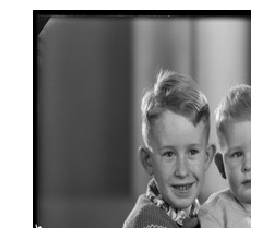

In [29]:
show_image(X_test, 0)